BIGRU Technology Specified

In [59]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import spacy
import lime
import shap



In [60]:
data = pd.read_csv('C:/Users/sachu/Desktop/DB/dbitats.csv')

# Basic data inspection

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8984 entries, 0 to 8983
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           8984 non-null   int64  
 1   Resume_str   8984 non-null   object 
 2   Category     8984 non-null   object 
 3   Title        8984 non-null   object 
 4   description  8984 non-null   object 
 5   ATS_Score    8984 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 421.3+ KB
None


        text_length   word_count
count   8984.000000  8984.000000
mean    7194.406834   912.542409
std     2279.472075   312.008902
min     2538.000000   321.000000
25%     5652.000000   695.000000
50%     6887.000000   871.000000
75%     8450.000000  1041.000000
max    16142.000000  2044.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


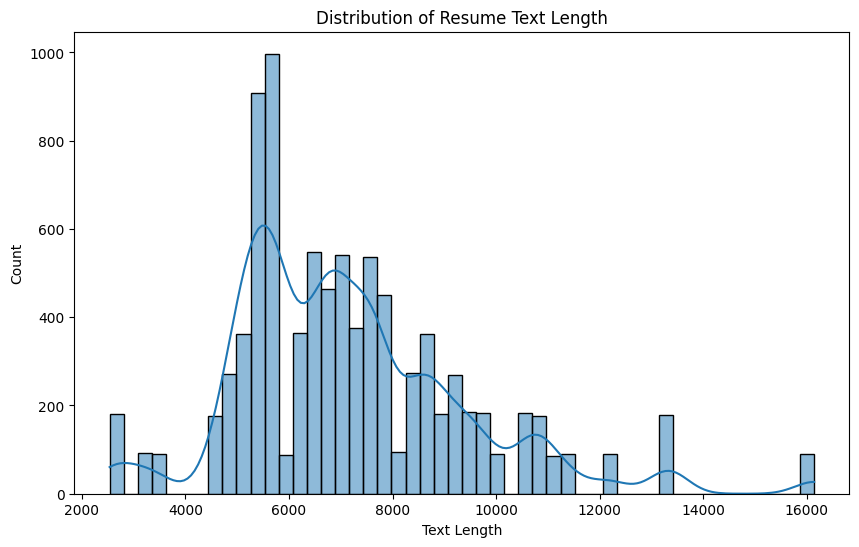

In [61]:
# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [62]:
import spacy

# Load the English model
nlp = spacy.load("en_core_web_sm")


# Abbreviations dictionary for job market
abbreviations = {
    "mgr": "manager",
    "sr": "senior",
    "jr": "junior",
    "asst": "assistant",
    "assoc": "associate",
    "dept": "department",
    "exp": "experience",
    "hr": "human resources",
    "acct": "account",
    "acctg": "accounting",
    "fin": "finance",
    "eng": "engineer",
    "engg": "engineering",
    "it": "information technology",
    "qa": "quality assurance",
    "dev": "development",
    "devops": "development operations",
    "proj": "project",
    "mktg": "marketing",
    "biz": "business",
    "comm": "communication",
    "adm": "administration",
    "sec": "secretary",
    "exec": "executive",
    "corp": "corporation",
    "intl": "international",
    "rep": "representative",
    "mfg": "manufacturing",
    "prod": "production",
    "purch": "purchasing",
    "sales": "sales",
    "cust": "customer",
    "svc": "service",
    "tech": "technical",
    "sup": "supervisor",
    "supv": "supervision",
    "log": "logistics",
    "inv": "inventory",
    "sch": "schedule",
    "edu": "education",
    "lang": "language",
    "pr": "public relations",
    "hrd": "human resources development",
    "cfo": "chief financial officer",
    "ceo": "chief executive officer",
    "coo": "chief operating officer",
    "cmo": "chief marketing officer",
    "cto": "chief technology officer",
    "cio": "chief information officer",
    "pmo": "project management office",
    "pmp": "project management professional",
    "ba": "business analyst",
    "bpm": "business process management",
    "ui": "user interface",
    "ux": "user experience",
    "svp": "senior vice president",
    "vp": "vice president",
    "gm": "general manager",
    "doe": "depends on experience",
    "r&d": "research and development",
    "seo": "search engine optimization",
    "sem": "search engine marketing",
    "smm": "social media marketing",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "kpi": "key performance indicator",
    "roi": "return on investment",
    "saas": "software as a service",
    "paas": "platform as a service",
    "iaas": "infrastructure as a service",
    "crm": "customer relationship management",
    "erp": "enterprise resource planning",
    "sd": "software development",
    "pm": "project manager",
    "pa": "personal assistant",
    "exec": "executive",
    "fin": "finance",
    "hrm": "human resources management",
    "it": "information technology",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "scm": "supply chain management",
    "seo": "search engine optimization",
    "smm": "social media marketing",
    "ux": "user experience",
    "ui": "user interface",
    "bi": "business intelligence",
    "dev": "development",
    "ops": "operations"
}


def expand_abbreviations(text, abbreviations):
    for abbr, expanded in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), expanded, text)
    return text

def clean_and_preprocess(text):
    text = expand_abbreviations(text, abbreviations)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    return nouns

# Apply cleaning and preprocessing
data['processed_resume'] = data['Resume_str'].apply(clean_and_preprocess)
data['processed_description'] = data['description'].apply(clean_and_preprocess)

# Extract nouns and combine processed text
data['nouns'] = data.apply(lambda row: extract_nouns(row['processed_resume'] + ' ' + row['processed_description']), axis=1)

# Ensure 'nouns' column is populated with lists
print(data['nouns'].head())

# Convert list of nouns to string
data['nouns_str'] = data['nouns'].apply(lambda x: ' '.join(x))

# Tokenizer and sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['nouns_str'])

nouns_sequences = tokenizer.texts_to_sequences(data['nouns_str'])
max_nouns_length = 10  # Adjust based on your data
nouns_data = pad_sequences(nouns_sequences, maxlen=max_nouns_length)

# Now you can use `nouns_data` in your model
print(nouns_data)
# Extract nouns and combine processed text

data['combined_text'] = data['processed_resume'] + ' ' + data['processed_description']
print(data['combined_text'].head())


0    [information, technology, manager, experience,...
1    [director, information, technology, career, ov...
2    [experience, information, technology, manager,...
3    [information, technology, coordinator, career,...
4    [information, executive, profile, technology, ...
Name: nouns, dtype: object
[[   9   18  999 ...  803  218  795]
 [ 161    7 2460 ...  218  191  234]
 [ 257   17  451 ... 1742  179 2485]
 ...
 [   7   11    9 ... 1264   11  491]
 [  11  513   11 ...  233  306   93]
 [1457   14   85 ...  177 1459  442]]
0    information technology manager experience info...
1    director information technology career overvie...
2    experience information technology manager expe...
3    information technology coordinator career over...
4    vp information technology executive profile re...
Name: combined_text, dtype: object


In [65]:
# Check the type of data
print(type(data))

# If it's not a DataFrame, let's reload the original data or re-create the DataFrame
# Example:
if not isinstance(data, pd.DataFrame):
    # Reload your original dataset or re-create the DataFrame as needed
    data = pd.read_csv('dbitats.csv')  # Replace with your actual data loading step


<class 'pandas.core.frame.DataFrame'>


In [71]:
# Tokenize combined text
tokenizer.fit_on_texts(data['combined_text'].values.tolist())

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['combined_text'].values)
word_index = tokenizer.word_index

# Padding sequences
max_sequence_length = 1500
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Target variable
y = data['ATS_Score'].values

print(data_padded.shape)
print(y.shape)

(8984, 1500)
(8984,)


In [75]:
print(y)

[75. 30. 60. ... 50. 50. 60.]


In [73]:
from sklearn.model_selection import train_test_split


# Split the data
# X_train_data, X_val_data, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(
#     data, nouns_data, labels, test_size=0.2, random_state=42
# )
X_train, X_test, X_train_nouns, X_test_nouns, y_train, y_test = train_test_split(data_padded, nouns_data,y, test_size=0.2, random_state=42)
X_train, X_val, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(X_train, X_train_nouns, y_train, test_size=0.2, random_state=42)
# Check shapes after splitting
print(f"X_train_data shape: {X_train.shape}")
print(f"X_train_nouns shape: {X_train_nouns.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_data shape: {X_val.shape}")
print(f"X_val_nouns shape: {X_val_nouns.shape}")
print(f"y_val shape: {y_val.shape}")


X_train_data shape: (5749, 1500)
X_train_nouns shape: (5749, 10)
y_train shape: (5749,)
X_val_data shape: (1438, 1500)
X_val_nouns shape: (1438, 10)
y_val shape: (1438,)


In [76]:
print (y_train)

[80. 60. 75. ... 60. 40. 60.]


In [68]:
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, concatenate, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Model Inputs
text_input = Input(shape=(max_sequence_length,), name='text_input')
nouns_input = Input(shape=(10,), name='nouns_input')

# Embedding Layer
embedding_dim = 100  # Adjust based on your embedding size
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)

# Apply Spatial Dropout
embedded_dropout = SpatialDropout1D(0.2)(embedding_layer)

# Bidirectional GRU Layer
gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3))(embedded_dropout)

# Global Average Pooling
gru_pool = GlobalAveragePooling1D()(gru)

# Dense Layers for Nouns Input
nouns_dense = Dense(32, activation='relu')(nouns_input)

# Combine GRU output with nouns dense layer
combined = concatenate([gru_pool, nouns_dense])

# Additional Dense Layers with Regularization
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Model definition
model = Model(inputs=[text_input, nouns_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1500, 100) │    785,200 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 1500, 100) │          0 │ embedding_2[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1500, 256) │    176,640 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nouns_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        352 │ nouns_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 288)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     18,496 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 982,801 (3.75 MB)

 Trainable params: 982,801 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# X_combined = np.concatenate([X_resume, X_description], axis=-1)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Define callbacks for early stopping, learning rate reduction, and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training the modified model
history = model.fit(
    [X_train, X_train_nouns], y_train,
    epochs=10,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=([X_val, X_val_nouns], y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([X_test, X_test_nouns], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - loss: 2208.9626 - mae: 38.1645 - val_loss: 831.8848 - val_mae: 24.6349 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 591s 7s/step - loss: 1334.3136 - mae: 30.0378 - val_loss: 759.4496 - val_mae: 23.7551 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 591s 7s/step - loss: 1018.2200 - mae: 26.1548 - val_loss: 504.1840 - val_mae: 19.0943 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - loss: 804.1197 - mae: 22.9229 - val_loss: 399.4404 - val_mae: 16.9315 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 692s 8s/step - loss: 663.3447 - mae: 20.8476 - val_loss: 386.1035 - val_mae: 16.9924 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 649s 7s/step - loss: 573.7599 - mae: 19.2913 - val_loss: 307.1530 - val_mae: 14.9443 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - loss: 535.8831 - mae: 18.5524 - val_loss: 310.3304 - val_mae: 

In [83]:
# Save the entire model to a file
model.save('bigruit.keras')

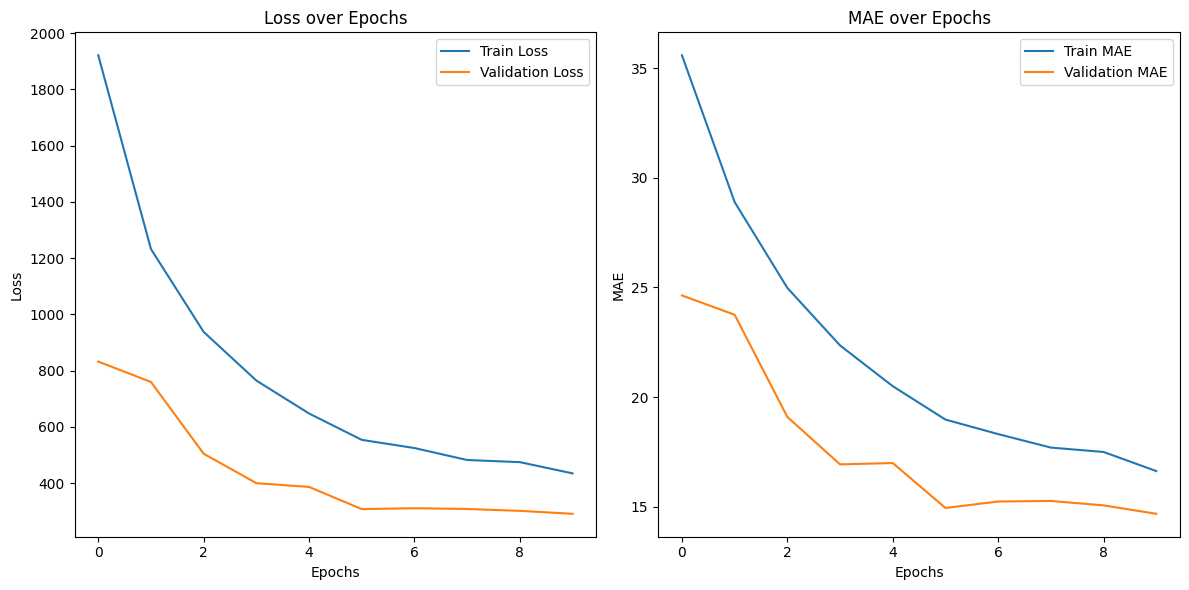

In [82]:
# Plot training history
import matplotlib.pyplot as plt


# Get history data from the History object
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
# Test model prediction on a batch of data
try:
    test_batch = [X_train_seq[:batch_size], X_train_additional[:batch_size]]
    predictions = model.predict(test_batch)
    print("Model predictions successful:", predictions.shape)
except Exception as e:
    print("Error during model prediction:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Model predictions successful: (5, 1)


In [95]:
import numpy as np
import shap
from tensorflow import keras
import gc

# Load the model
model = keras.models.load_model('bigruit.keras')

# Define a function to wrap your model for SHAP
def model_predict(input_data):
    return model.predict(input_data)

# Assuming X_train_seq is your first input and X_train_additional is your second input
X_train_seq = np.array(X_train)  # Your original input data
X_train_additional = np.array(X_train_nouns)  # Your second input data

# Reshape X_train_seq to (n_samples, 1500)
if X_train_seq.shape[1] < 1500:
    padding = np.zeros((X_train_seq.shape[0], 1500 - X_train_seq.shape[1]))
    X_train_seq = np.concatenate((X_train_seq, padding), axis=1)
elif X_train_seq.shape[1] > 1500:
    X_train_seq = X_train_seq[:, :1500]

# Reshape X_train_additional to (n_samples, 10)
if X_train_additional.shape[1] < 10:
    padding = np.zeros((X_train_additional.shape[0], 10 - X_train_additional.shape[1]))
    X_train_additional = np.concatenate((X_train_additional, padding), axis=1)
elif X_train_additional.shape[1] > 10:
    X_train_additional = X_train_additional[:, :10]

# Sample background data
K = 50  # Sample size for SHAP background data
background_data_1 = shap.sample(X_train_seq, K)
background_data_2 = shap.sample(X_train_additional, K)

# Concatenate background data
background_data = np.concatenate([background_data_1, background_data_2], axis=1)

# Combine inputs for prediction
def combined_predict(inputs):
    inputs_seq, inputs_additional = np.split(inputs, [1500], axis=1)
    return model_predict([inputs_seq, inputs_additional])

# Use KernelExplainer with the combined prediction function
explainer = shap.KernelExplainer(combined_predict, background_data)

# Calculate SHAP values for the training data in smaller batches
batch_size = 3
shap_values = []

for i in range(0, X_train_seq.shape[0], batch_size):
    batch_1 = X_train_seq[i:i + batch_size]
    batch_2 = X_train_additional[i:i + batch_size]
    batch = np.concatenate([batch_1, batch_2], axis=1)
    shap_values_batch = explainer.shap_values(batch)
    shap_values.append(shap_values_batch)
    gc.collect()

# Concatenate the SHAP values from all batches
shap_values = [np.concatenate([shap_values_batch[0] for shap_values_batch in shap_values], axis=0),
               np.concatenate([shap_values_batch[1] for shap_values_batch in shap_values], axis=0)]

# Visualize the SHAP values for the first instance of the first input
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train_seq[0])

c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
7148/7919 ━━━━━━━━━━━━━━━━━━━━ 1:32:35 7s/step